In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from skimage.transform import resize

In [55]:
fpP = "Parasitized/"
fpU = "Uninfected/"

In [56]:
import os
os.listdir()

['Parasitized', 'Uninfected', '.ipynb_checkpoints', 'final_project.ipynb']

In [57]:


dataP = []
count = 0
for filename in os.listdir(fpP):
    if '.png' in filename:
        count += 1
        if count>100:
            break
        print(filename)
        dataP.append(resize(mpimg.imread(fpP+filename), (299,299,3)))
        


C33P1thinF_IMG_20150619_115740a_cell_162.png
C33P1thinF_IMG_20150619_114756a_cell_182.png
C33P1thinF_IMG_20150619_114756a_cell_180.png
C33P1thinF_IMG_20150619_115740a_cell_161.png
C33P1thinF_IMG_20150619_114756a_cell_179.png
C33P1thinF_IMG_20150619_114756a_cell_181.png
C33P1thinF_IMG_20150619_115740a_cell_163.png
C33P1thinF_IMG_20150619_115808a_cell_205.png


In [58]:
dataU = []
count = 0
for filename in os.listdir(fpU):
    if '.png' in filename:
        count+=1
        if count>100:
            break
        print(filename)
        dataU.append(resize(mpimg.imread(fpU+filename), (299, 299, 3)))

C1_thinF_IMG_20150604_104722_cell_66.png
C1_thinF_IMG_20150604_104722_cell_73.png
C1_thinF_IMG_20150604_104722_cell_15.png
C1_thinF_IMG_20150604_104722_cell_81.png
C1_thinF_IMG_20150604_104722_cell_115.png
C1_thinF_IMG_20150604_104722_cell_60.png
C1_thinF_IMG_20150604_104722_cell_79.png
C1_thinF_IMG_20150604_104722_cell_9.png


In [59]:
# dataP = np.stack(dataP, axis=0)
# dataU = np.stack(dataU, axis=0)
dataP = np.array(dataP)
dataU = np.array(dataU)

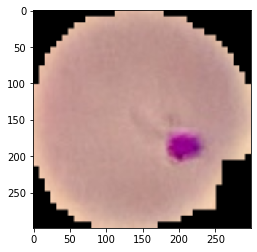

In [60]:

plt.imshow(dataP[0])


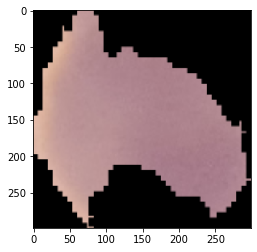

In [61]:
plt.imshow(dataU[0])

In [62]:
dataP /= 255
dataU /= 255

#TODO: Data preprocessing: only use PERCENT_DATA_USED of the train/test images and labels
PERCENT_TRAINED = 0.8
num_P = int(len(dataP) * PERCENT_TRAINED)
num_U = int(len(dataU) * PERCENT_TRAINED)

U_train = dataU[:num_U]
U_test = dataU[num_U:]
P_train = dataP[:num_P]
P_test = dataP[num_P:]


X_train = np.concatenate([list(U_train), list(P_train)])
X_test = np.concatenate([list(U_test), list(P_test)])
y_train = num_U*[0]+num_P*[1] #uninfected is 0, parasitized is 1
y_test = (len(dataU)-num_U)*[0]+(len(dataP)-num_P)*[1]

In [63]:
dataP

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [69]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.losses import binary_crossentropy

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer='rmsprop', loss=binary_crossentropy)

# train the model on the new data for a few epochs
model.fit(X_train, y_train, batch_size = 32, epochs = 3)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=binary_crossentropy)

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train, y_train, batch_size = 32, epochs = 3, validation_data=(X_test, y_test))

Epoch 1/3
12/12 [==============================] - 24s 2s/step - loss: 7.9712
Epoch 2/3
12/12 [==============================] - 3s 223ms/step - loss: 7.9712
Epoch 3/3
12/12 [==============================] - 3s 225ms/step - loss: 7.9712
0 input_6
1 conv2d_471
2 batch_normalization_471
3 activation_471
4 conv2d_472
5 batch_normalization_472
6 activation_472
7 conv2d_473
8 batch_normalization_473
9 activation_473
10 max_pooling2d_21
11 conv2d_474
12 batch_normalization_474
13 activation_474
14 conv2d_475
15 batch_normalization_475
16 activation_475
17 max_pooling2d_22
18 conv2d_479
19 batch_normalization_479
20 activation_479
21 conv2d_477
22 conv2d_480
23 batch_normalization_477
24 batch_normalization_480
25 activation_477
26 activation_480
27 average_pooling2d_46
28 conv2d_476
29 conv2d_478
30 conv2d_481
31 conv2d_482
32 batch_normalization_476
33 batch_normalization_478
34 batch_normalization_481
35 batch_normalization_482
36 activation_476
37 activation_478
38 activation_481
39 acti

AttributeError: 'Model' object has no attribute 'accuracy'

In [ ]:
type(X_train)

In [ ]:
base_model.input

In [ ]:
dataU.shape

In [ ]:
dataU[0][0][0]

In [ ]:
dataU.shape